# Modelo Preditivo para Visualização de Incêndios em Portugal
Catarina Cruz e Tiago Lopes, MECD 2024/25

## 1. Configuração e Importações


In [1]:
#!pip install --quiet --upgrade numpy pandas matplotlib scikit-learn pmdarima xgboost statsmodels seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Modelos de Séries Temporais
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR

# Modelos de Machine Learning
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Métricas de Avaliação
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report

# Configurações visuais
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (8, 3)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

## 2. Carregamento e Preparação dos Dados


In [3]:
df = pd.read_csv('incendios_2012a2021.csv')

In [4]:
df.head()

,id,DISTRITO,TIPO,ANO,AREAPOV,AREAMATO,AREAAGRIC,AREATOTAL,REACENDIMENTOS,FALSOALARME,...,TEMPERATURA,HUMIDADERELATIVA,VENTOINTENSIDADE,VENTOINTENSIDADE_VETOR,VENTODIRECAO_VETOR,ALTITUDEMEDIA,DECLIVEMEDIO,DENDIDADERV,COSN5VARIEDADE,ESTACAO
0,AG11217,Faro,Florestal,2012,0.0000,2.0000,0.0,2.0000,0,0,...,13.044220,60.355878,25.619265,6.611052,1.0,51.3787,29.0175,221.6560,11.78,Inverno
1,AG112183,Faro,Florestal,2012,2.0519,0.3076,0.0,2.3595,0,0,...,17.477997,26.022594,17.476209,5.051042,324.0,260.2370,29.2794,265.5130,8.30,Primavera
2,AG112189,Faro,Florestal,2012,0.0000,1.1500,0.0,1.1500,0,0,...,16.401001,65.835898,14.326569,3.767304,103.0,767.4720,30.8692,288.4600,10.28,Primavera
3,AG112213,Faro,Florestal,2012,1.2000,0.0000,0.0,1.2000,0,0,...,14.227692,60.986726,34.054126,9.915043,329.0,37.8237,10.2037,258.0660,11.14,Primavera
4,AG112216,Faro,Florestal,2012,1.3000,0.0000,0.0,1.3000,0,0,...,15.692719,74.894374,28.617102,7.865825,332.0,162.6790,33.7764,77.4753,5.23,Primavera


In [5]:
df["DATAALERTA"] = pd.to_datetime(df["DATAALERTA"], errors="coerce")
df['DATAEXTINCAO'] = pd.to_datetime(df['DATAEXTINCAO'], errors="coerce")
df['DHINICIO'] = pd.to_datetime(df['DHINICIO'], errors="coerce")
df['DHFIM'] = pd.to_datetime(df['DHFIM'], errors="coerce")

In [6]:
# Calcular duração em horas a partir de DATAALERTA e DATAEXTINCAO
df['DURACAO_HORAS'] = (df['DATAEXTINCAO'] - df['DATAALERTA']).dt.total_seconds() / 3600

In [7]:
df['ANO'] = df['DATAALERTA'].dt.year
df['MES'] = df['DATAALERTA'].dt.month
df['DIA'] = df['DATAALERTA'].dt.day
df['DIASEMANA'] = df['DATAALERTA'].dt.dayofweek  # 0=Segunda, 6=Domingo

In [8]:
df['MES_SIN'] = np.sin(2 * np.pi * df['MES'] / 12)
df['MES_COS'] = np.cos(2 * np.pi * df['MES'] / 12)
df['DIA_SIN'] = np.sin(2 * np.pi * df['DIASEMANA'] / 7)
df['DIA_COS'] = np.cos(2 * np.pi * df['DIASEMANA'] / 7)

In [9]:
df['INDICE_SECURA'] = df['TEMPERATURA'] * (100 - df['HUMIDADERELATIVA']) / 100

In [10]:
df = df.dropna(subset=['DATAALERTA', 'DATAEXTINCAO', 'LAT', 'LON', 'TEMPERATURA', 'HUMIDADERELATIVA', 'VENTOINTENSIDADE'])

In [11]:
# Verificar e tratar outliers nas variáveis numéricas
def tratar_outliers(df, coluna, limite_inferior=0.001, limite_superior=0.999):
    """Trata outliers substituindo valores extremos pelos percentis"""
    q_inf = df[coluna].quantile(limite_inferior)
    q_sup = df[coluna].quantile(limite_superior)
    
    df.loc[df[coluna] < q_inf, coluna] = q_inf
    df.loc[df[coluna] > q_sup, coluna] = q_sup
    
    return df

for col in ['TEMPERATURA', 'HUMIDADERELATIVA', 'VENTOINTENSIDADE', 'AREATOTAL', 'DURACAO_HORAS']:
    if col in df.columns:
        print(f"Tratando outliers em {col}")
        df = tratar_outliers(df, col)

Tratando outliers em TEMPERATURA
Tratando outliers em HUMIDADERELATIVA
Tratando outliers em VENTOINTENSIDADE
Tratando outliers em AREATOTAL
Tratando outliers em DURACAO_HORAS


In [12]:
# Verificar informações básicas do dataframe após processamento
print("\nInformações do dataframe após processamento:")
print(f"Dimensões: {df.shape}")
print(f"Período: {df['DATAALERTA'].min().date()} a {df['DATAALERTA'].max().date()}")
print(f"Total de incêndios: {len(df)}")


Informações do dataframe após processamento:
Dimensões: (22335, 46)
Período: 2012-01-06 a 2021-12-19
Total de incêndios: 22335


## 3. Análise Exploratória

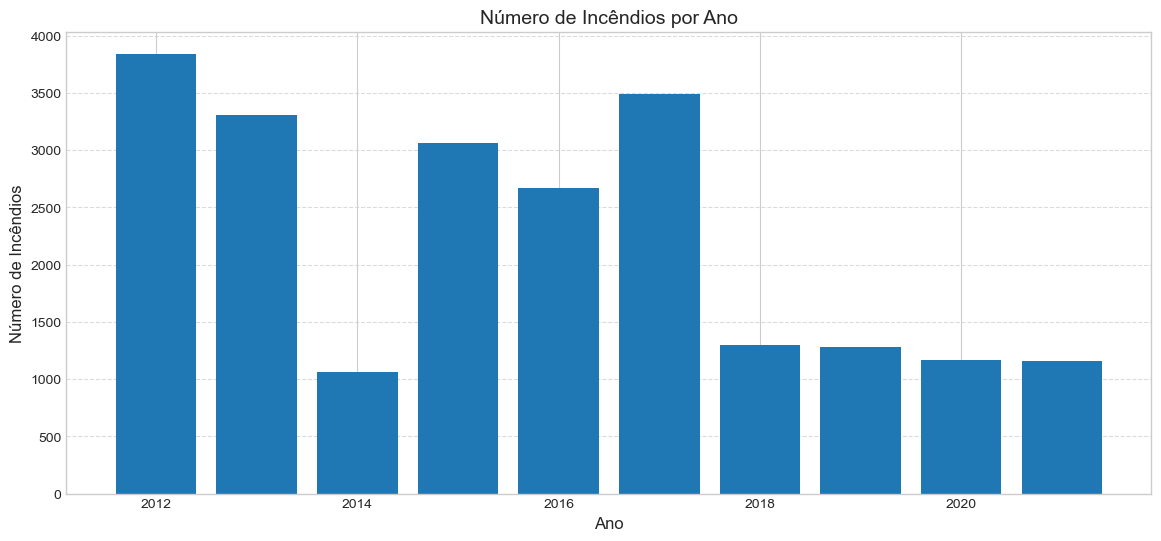

In [13]:
plt.figure(figsize=(14, 6))
df_count_by_year = df.groupby('ANO').size()
plt.bar(df_count_by_year.index, df_count_by_year.values)
plt.title('Número de Incêndios por Ano')
plt.xlabel('Ano')
plt.ylabel('Número de Incêndios')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

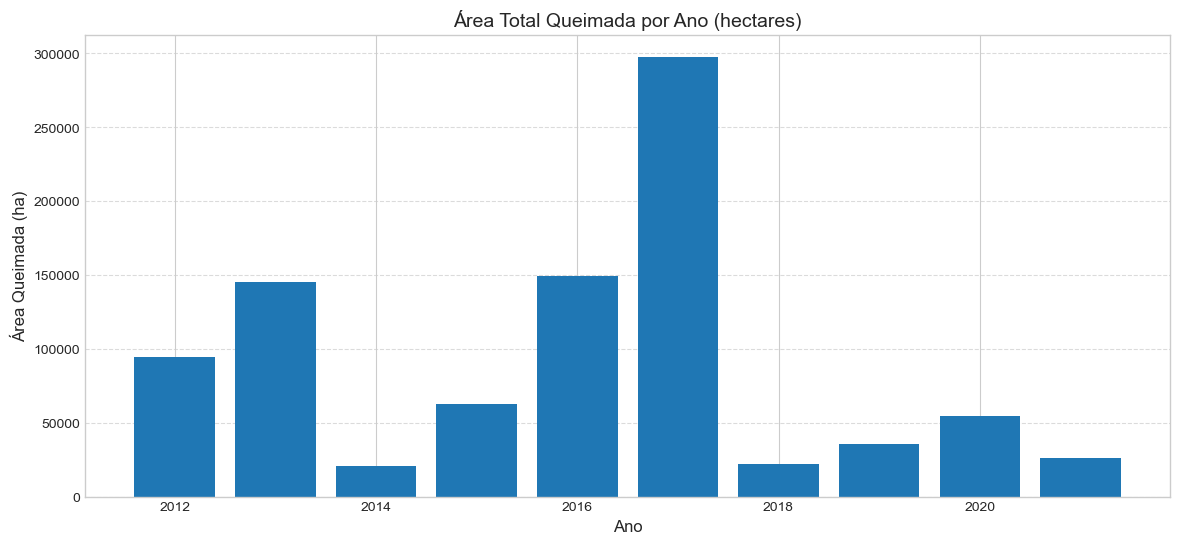

In [14]:
# Área total queimada por ano
plt.figure(figsize=(14, 6))
df_area_by_year = df.groupby('ANO')['AREATOTAL'].sum()
plt.bar(df_area_by_year.index, df_area_by_year.values)
plt.title('Área Total Queimada por Ano (hectares)')
plt.xlabel('Ano')
plt.ylabel('Área Queimada (ha)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

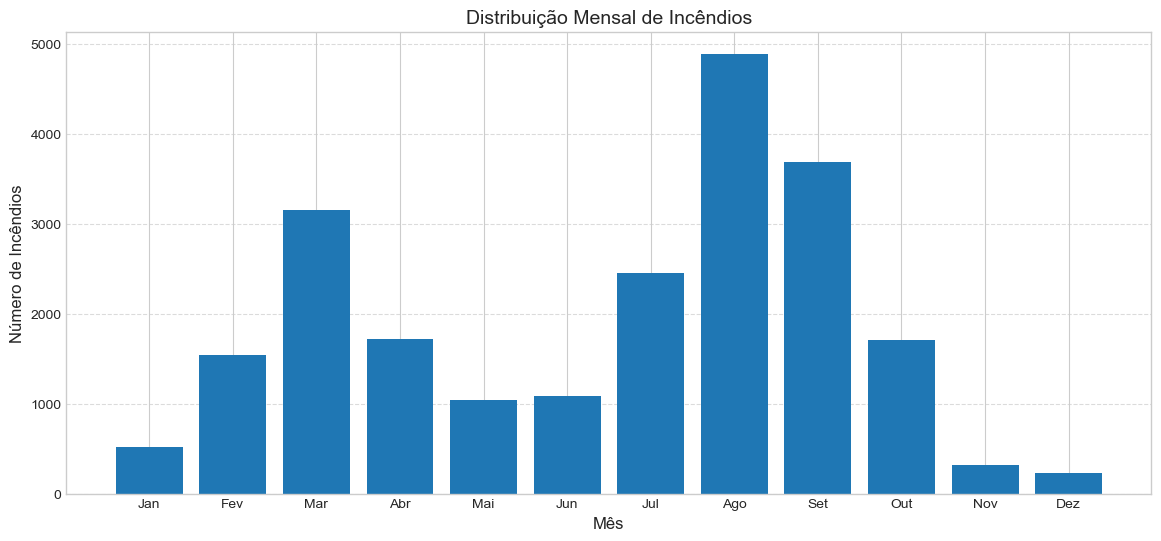

In [15]:
# Distribuição mensal de incêndios
plt.figure(figsize=(14, 6))
df_count_by_month = df.groupby('MES').size()
plt.bar(df_count_by_month.index, df_count_by_month.values)
plt.title('Distribuição Mensal de Incêndios')
plt.xlabel('Mês')
plt.ylabel('Número de Incêndios')
plt.xticks(range(1, 13), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

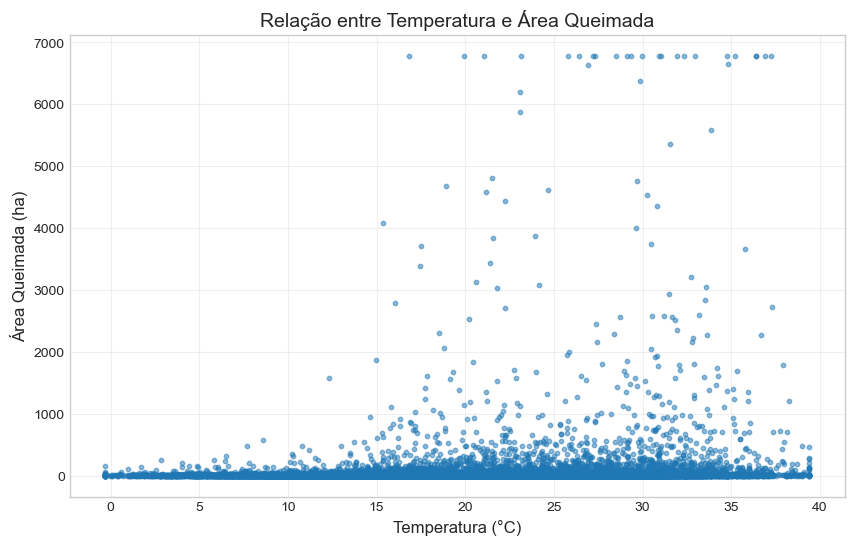

In [16]:
# Relação entre temperatura e área queimada
plt.figure(figsize=(10, 6))
plt.scatter(df['TEMPERATURA'], df['AREATOTAL'], alpha=0.5, s=10)
plt.title('Relação entre Temperatura e Área Queimada')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Área Queimada (ha)')
plt.grid(True, alpha=0.3)
plt.show()

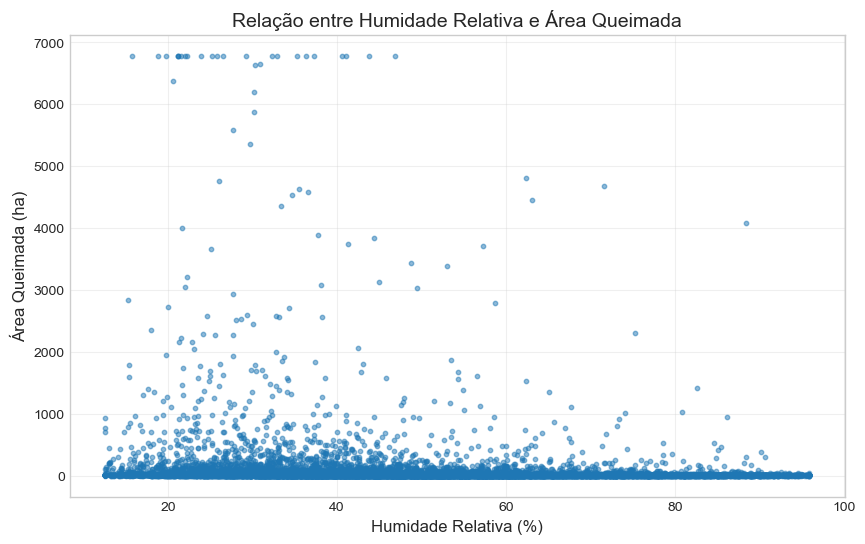

In [17]:
# Relação entre humidade e área queimada
plt.figure(figsize=(10, 6))
plt.scatter(df['HUMIDADERELATIVA'], df['AREATOTAL'], alpha=0.5, s=10)
plt.title('Relação entre Humidade Relativa e Área Queimada')
plt.xlabel('Humidade Relativa (%)')
plt.ylabel('Área Queimada (ha)')
plt.grid(True, alpha=0.3)
plt.show()

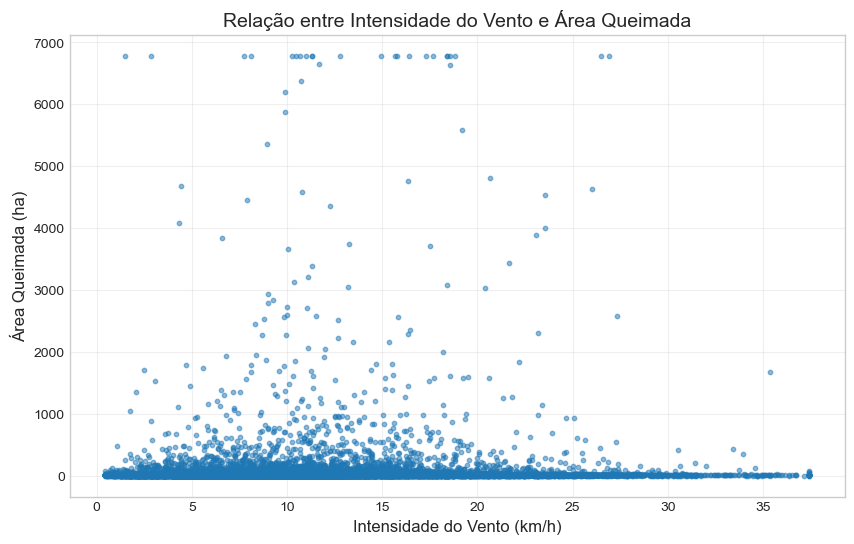

In [18]:
# Relação entre intensidade do vento e área queimada
plt.figure(figsize=(10, 6))
plt.scatter(df['VENTOINTENSIDADE'], df['AREATOTAL'], alpha=0.5, s=10)
plt.title('Relação entre Intensidade do Vento e Área Queimada')
plt.xlabel('Intensidade do Vento (km/h)')
plt.ylabel('Área Queimada (ha)')
plt.grid(True, alpha=0.3)
plt.show()

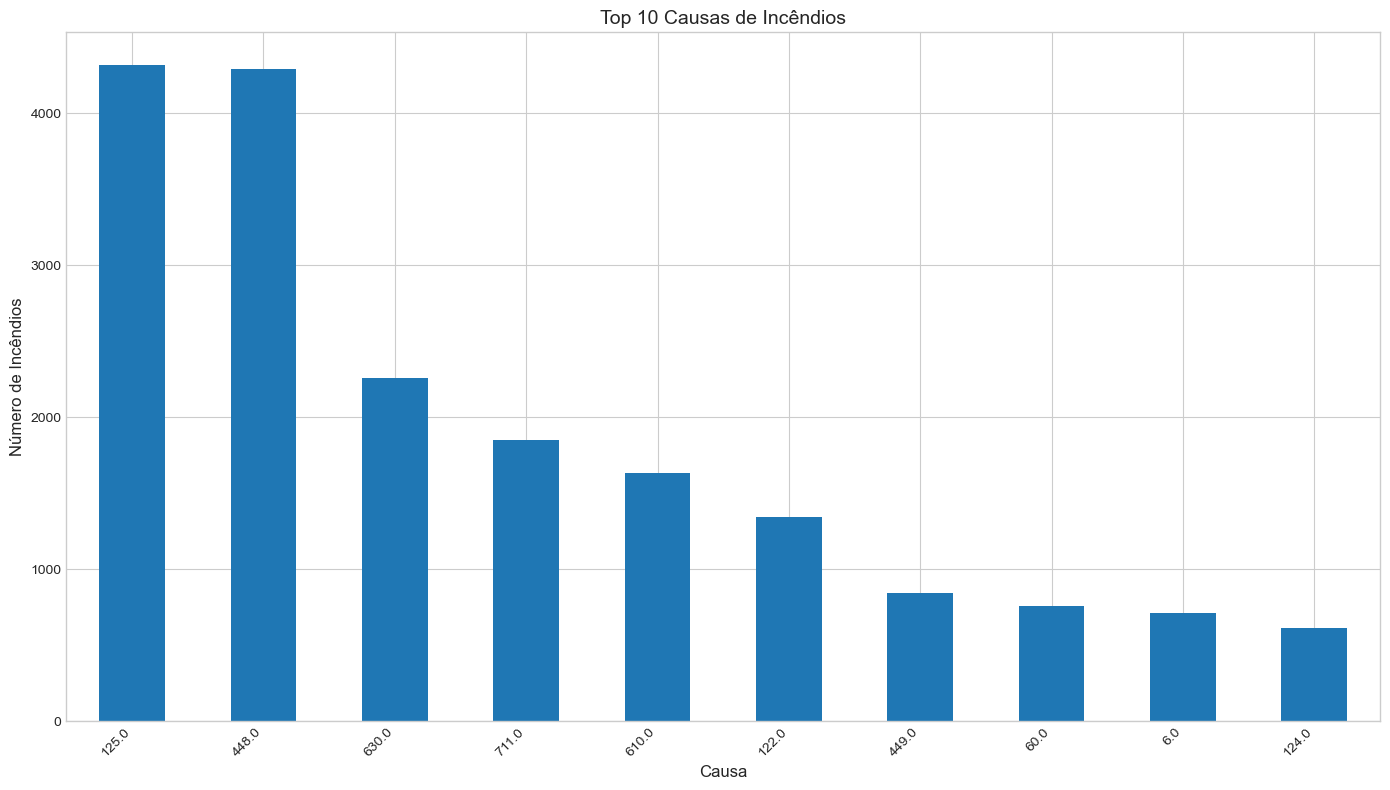

In [19]:
# Distribuição das causas de incêndio
if 'CAUSA' in df.columns:
    plt.figure(figsize=(14, 8))
    causas_count = df['CAUSA'].value_counts().sort_values(ascending=False).head(10)
    causas_count.plot(kind='bar')
    plt.title('Top 10 Causas de Incêndios')
    plt.xlabel('Causa')
    plt.ylabel('Número de Incêndios')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


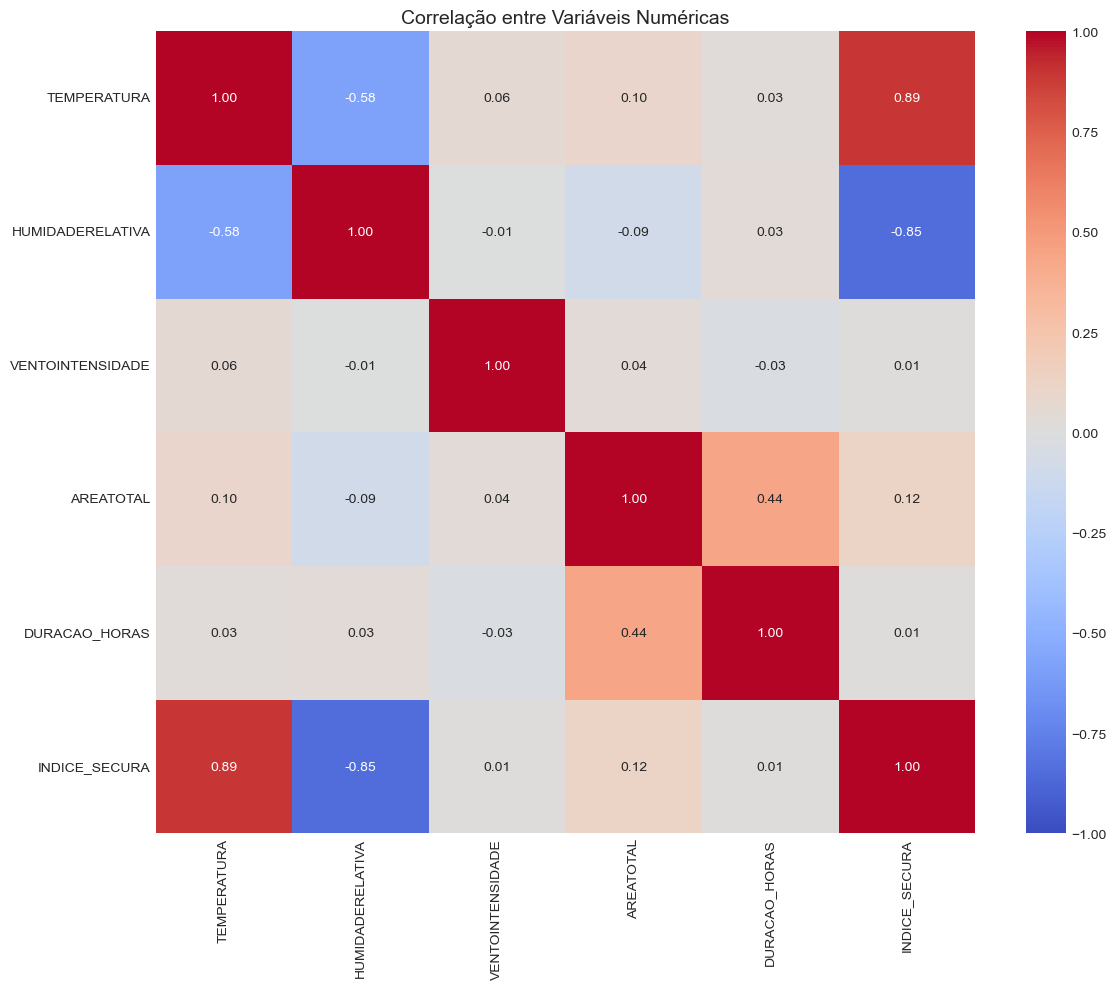

In [20]:
# Mapa de calor de correlação entre variáveis numéricas
cols_numericas = ['TEMPERATURA', 'HUMIDADERELATIVA', 'VENTOINTENSIDADE', 
                  'AREATOTAL', 'DURACAO_HORAS', 'INDICE_SECURA']
plt.figure(figsize=(12, 10))
corr = df[cols_numericas].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlação entre Variáveis Numéricas')
plt.tight_layout()
plt.show()

## 4. Modelos Preditivos

Iniciamos a fase de modelagem preditiva. Como primeiro passo, dividimos os nossos dados num conjunto de treino e num conjunto de teste. Adotamos uma divisão temporal:
- os dados de 2012 a 2020 são usados para treinar os modelos, 
- enquanto os dados de 2021 servem como conjunto de teste, não visto pelos modelos durante o treino.

In [21]:
# Criar conjuntos de treino e teste
# Treino: 2012-2020, Teste: 2021
df_train = df[df['ANO'] <= 2020].copy()
df_test = df[df['ANO'] == 2021].copy()

print(f"Conjunto de treino: {len(df_train)} registos")
print(f"Conjunto de teste: {len(df_test)} registos")

Conjunto de treino: 21173 registos
Conjunto de teste: 1162 registos


### Variáveis Meteorológicas

O primeiro objetivo é prever as condições meteorológicas médias mensais futuras, que servirão de input para outros modelos (ex: previsão do número de incêndios - como veremos daqui para a frente).

Como não temos previsões meteorológicas externas, criamos modelos base simples que usam apenas o Mês e o Ano como features.
- Os dados são agregados mensalmente para obter médias de Temperatura, Humidade e Vento.
- Um modelo Random Forest Regressor distinto é treinado para cada variável meteorológica.
- A performance é avaliada no conjunto de teste de 2021 (MAE, RMSE) e visualmente através de gráficos que comparam os valores reais e previstos.

Variável: TEMPERATURA
MAE: 1.06
RMSE: 1.36


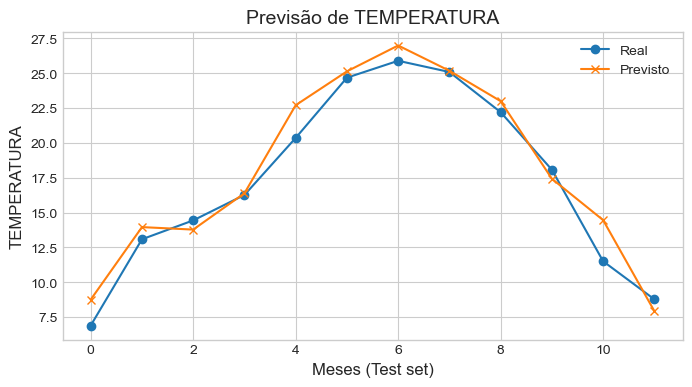

Variável: HUMIDADERELATIVA
MAE: 4.40
RMSE: 5.21


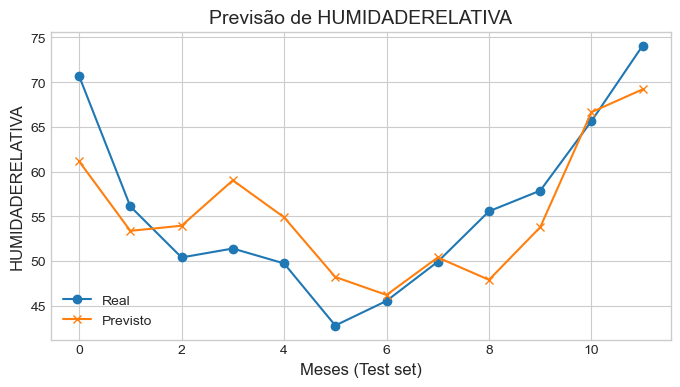

Variável: VENTOINTENSIDADE
MAE: 1.50
RMSE: 1.82


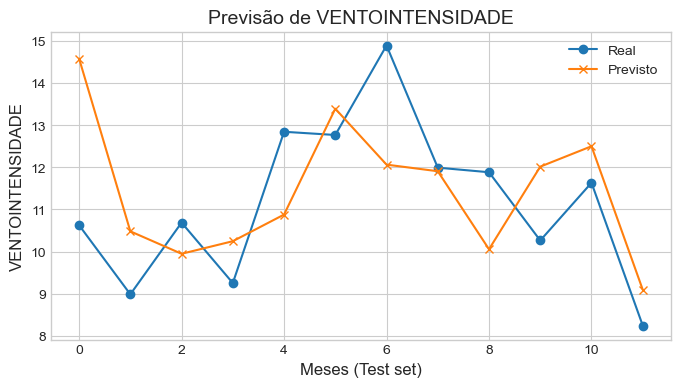

In [22]:
# 2. Processar datas
df['DATAALERTA'] = pd.to_datetime(df['DATAALERTA'], errors='coerce')
df = df.dropna(subset=['DATAALERTA'])

# 3. Agrupar por mês
meteo = df.groupby(pd.Grouper(key='DATAALERTA', freq='M')).agg({
    'TEMPERATURA': 'mean',
    'HUMIDADERELATIVA': 'mean',
    'VENTOINTENSIDADE': 'mean'
}).reset_index()

# Eliminar linhas com NaN nas variáveis meteorológicas
meteo = meteo.dropna(subset=['TEMPERATURA', 'HUMIDADERELATIVA', 'VENTOINTENSIDADE'])

# 4. Features temporais
meteo['MES'] = meteo['DATAALERTA'].dt.month
meteo['ANO'] = meteo['DATAALERTA'].dt.year

# 5. Remover a coluna de datas (não pode ser input)
X = meteo[['MES', 'ANO']]

# 6. Função para treinar e avaliar
def treinar_modelo(y_column):
    y = meteo[y_column]
    X_train, X_test = X.iloc[:-12], X.iloc[-12:]  # Treinar até 2020, testar em 2021
    y_train, y_test = y.iloc[:-12], y.iloc[-12:]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f'Variável: {y_column}')
    print(f'MAE: {mae:.2f}')
    print(f'RMSE: {rmse:.2f}')

    # Gráfico real vs previsto
    plt.figure(figsize=(8,4))
    plt.plot(y_test.values, label='Real', marker='o')
    plt.plot(y_pred, label='Previsto', marker='x')
    plt.title(f'Previsão de {y_column}')
    plt.xlabel('Meses (Test set)')
    plt.ylabel(y_column)
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

# 7. Treinar para cada variável meteorológica
model_temp = treinar_modelo('TEMPERATURA')
model_hum = treinar_modelo('HUMIDADERELATIVA')
model_vento = treinar_modelo('VENTOINTENSIDADE')

- Temperatura: o modelo captou super bem o padrão anual (curva de verão/inverno).
- Humidade: algum desvio (especialmente nas viragens de estação) — normal, é mais difícil prever humidade só com mês/ano.
- Vento: razoavel.

### Número de Incêndios

O passo seguinte é prever o número total de incêndios que ocorrem a cada mês.
Vamos testar duas abordagens.

Número de Incêndios:
MAE: 86.17
RMSE: 127.60


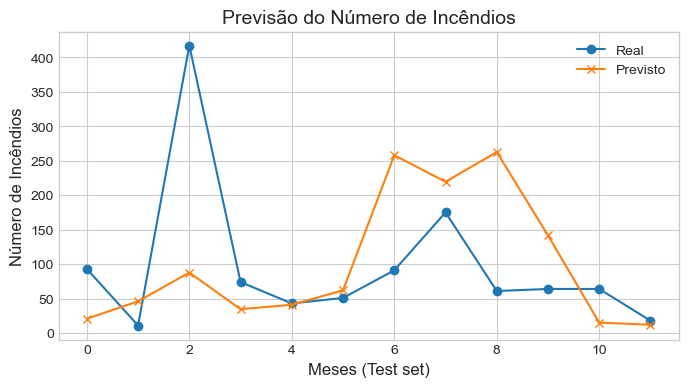

In [23]:
# 1. Agrupar dados: contar incêndios por mês
incendios = df.groupby(pd.Grouper(key='DATAALERTA', freq='M')).agg({'id': 'count'}).reset_index()

incendios.rename(columns={'id': 'NUM_INCENDIOS'}, inplace=True)

# 2. Features temporais
incendios['MES'] = incendios['DATAALERTA'].dt.month
incendios['ANO'] = incendios['DATAALERTA'].dt.year

# 3. Remover datas
X_inc = incendios[['MES', 'ANO']]
y_inc = incendios['NUM_INCENDIOS']

# 4. Dividir treino/teste
X_train_inc, X_test_inc = X_inc.iloc[:-12], X_inc.iloc[-12:]
y_train_inc, y_test_inc = y_inc.iloc[:-12], y_inc.iloc[-12:]

# 5. Treinar modelo
model_incendios = RandomForestRegressor(n_estimators=100, random_state=42)
model_incendios.fit(X_train_inc, y_train_inc)

# 6. Prever
y_pred_inc = model_incendios.predict(X_test_inc)

# 7. Avaliação
mae_inc = mean_absolute_error(y_test_inc, y_pred_inc)
rmse_inc = np.sqrt(mean_squared_error(y_test_inc, y_pred_inc))

print('Número de Incêndios:')
print(f'MAE: {mae_inc:.2f}')
print(f'RMSE: {rmse_inc:.2f}')

# 8. Gráfico real vs previsto
plt.figure(figsize=(8,4))
plt.plot(y_test_inc.values, label='Real', marker='o')
plt.plot(y_pred_inc, label='Previsto', marker='x')
plt.title('Previsão do Número de Incêndios')
plt.xlabel('Meses (Test set)')
plt.ylabel('Número de Incêndios')
plt.legend()
plt.grid(True)
plt.show()


Acho que sim, reveu bem! pois neste ano houve muitos incendios em fevereiro, mais que no inverno até, mas isso não é comum! foi pontual

abordagem 2

Para ver se conseguimos prever melhor, vamos usar a temperatura, humidade e a intensidade do vento como input

Número de Incêndios (Modelo Melhorado):
MAE: 69.66
RMSE: 84.36


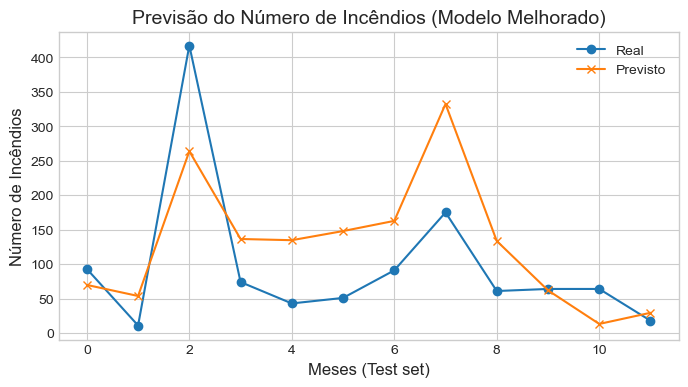

In [24]:
# 1. Agrupar incêndios
incendios = df.groupby(pd.Grouper(key='DATAALERTA', freq='M')).agg({
    'id': 'count'
}).reset_index()

incendios.rename(columns={'id': 'NUM_INCENDIOS'}, inplace=True)

# 2. Agrupar meteorologia
meteo = df.groupby(pd.Grouper(key='DATAALERTA', freq='M')).agg({
    'TEMPERATURA': 'mean',
    'HUMIDADERELATIVA': 'mean',
    'VENTOINTENSIDADE': 'mean'
}).reset_index()

# 3. Juntar datasets
dataset = pd.merge(incendios, meteo, on='DATAALERTA')

# 4. Features temporais
dataset['MES'] = dataset['DATAALERTA'].dt.month
dataset['ANO'] = dataset['DATAALERTA'].dt.year

# 5. Preparar X e y
X = dataset[['MES', 'ANO', 'TEMPERATURA', 'HUMIDADERELATIVA', 'VENTOINTENSIDADE']]
y = dataset['NUM_INCENDIOS']

# 6. Remover possíveis NaNs
X = X.dropna()
y = y[X.index]

# 7. Dividir treino/teste
X_train, X_test = X.iloc[:-12], X.iloc[-12:]
y_train, y_test = y.iloc[:-12], y.iloc[-12:]

# 8. Treinar modelo
model_incendios_melhorado = RandomForestRegressor(n_estimators=100, random_state=42)
model_incendios_melhorado.fit(X_train, y_train)

# 9. Prever
y_pred = model_incendios_melhorado.predict(X_test)

# 10. Avaliação
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('Número de Incêndios (Modelo Melhorado):')
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

# 11. Gráfico real vs previsto
plt.figure(figsize=(8,4))
plt.plot(y_test.values, label='Real', marker='o')
plt.plot(y_pred, label='Previsto', marker='x')
plt.title('Previsão do Número de Incêndios (Modelo Melhorado)')
plt.xlabel('Meses (Test set)')
plt.ylabel('Número de Incêndios')
plt.legend()
plt.grid(True)
plt.show()


Realmente melhorou!!

### Variáveis Geográficas

Fizemos o mesmo processo, usamos as features ja previstas e usamos para prever as variaveis geograficas

Tentamos agora prever a área total ardida (`AREATOTAL`) por mês.
Seguimos uma abordagem semelhante à previsão do número de incêndios (abordagem 2), utilizando o Mês, Ano e as médias mensais das variáveis meteorológicas como preditores.
 - Agregamos a soma da `AREATOTAL` por mês e juntamos com os dados meteorológicos.
 - Treinamos um Random Forest Regressor.
 - A avaliação revela um desafio significativo: a área ardida é extremamente variável e propensa a valores muito elevados (outliers) devido a grandes incêndios (como os de 2017). Isto resulta em métricas de erro (MAE, RMSE) elevadas, mesmo que o modelo consiga capturar a tendência sazonal geral.

Área Total Ardida (Modelo Melhorado):
MAE: 5018.22
RMSE: 7863.65


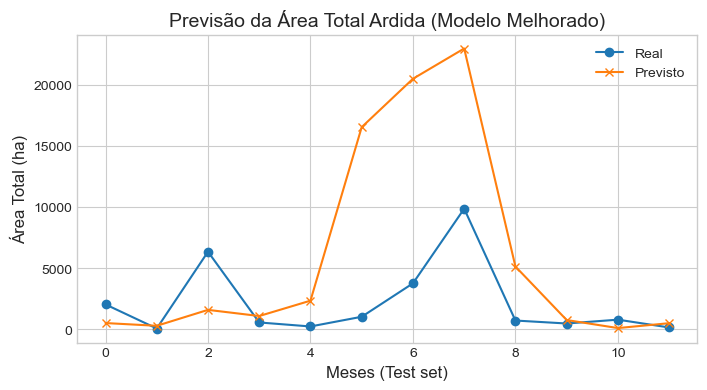

In [25]:
# 1. Agrupar área ardida
areas = df.groupby(pd.Grouper(key='DATAALERTA', freq='M')).agg({'AREATOTAL': 'sum'}).reset_index()

# 2. Agrupar meteorologia (já feito antes, mas vamos garantir)
meteo = df.groupby(pd.Grouper(key='DATAALERTA', freq='M')).agg({'TEMPERATURA': 'mean', 'HUMIDADERELATIVA': 'mean', 'VENTOINTENSIDADE': 'mean'}).reset_index()

# 3. Juntar datasets
dataset_area = pd.merge(areas, meteo, on='DATAALERTA')

# 4. Features temporais
dataset_area['MES'] = dataset_area['DATAALERTA'].dt.month
dataset_area['ANO'] = dataset_area['DATAALERTA'].dt.year

# 5. Preparar X e y
X_area = dataset_area[['MES', 'ANO', 'TEMPERATURA', 'HUMIDADERELATIVA', 'VENTOINTENSIDADE']]
y_area = dataset_area['AREATOTAL']

# 6. Remover possíveis NaNs
X_area = X_area.dropna()
y_area = y_area[X_area.index]

# 7. Dividir treino/teste
X_train_area, X_test_area = X_area.iloc[:-12], X_area.iloc[-12:]
y_train_area, y_test_area = y_area.iloc[:-12], y_area.iloc[-12:]

# 8. Treinar modelo
model_area = RandomForestRegressor(n_estimators=100, random_state=42)
model_area.fit(X_train_area, y_train_area)

# 9. Prever
y_pred_area = model_area.predict(X_test_area)

# 10. Avaliação
mae_area = mean_absolute_error(y_test_area, y_pred_area)
rmse_area = np.sqrt(mean_squared_error(y_test_area, y_pred_area))

print('Área Total Ardida (Modelo Melhorado):')
print(f'MAE: {mae_area:.2f}')
print(f'RMSE: {rmse_area:.2f}')

# 11. Gráfico real vs previsto
plt.figure(figsize=(8,4))
plt.plot(y_test_area.values, label='Real', marker='o')
plt.plot(y_pred_area, label='Previsto', marker='x')
plt.title('Previsão da Área Total Ardida (Modelo Melhorado)')
plt.xlabel('Meses (Test set)')
plt.ylabel('Área Total (ha)')
plt.legend()
plt.grid(True)
plt.show()


O erro parece grande à primeira vista, mas faz sentido porque:
- Área ardida é extremamente variável (pode ir de 10 hectares para 100.000 hectares de um mês para o outro).
- Grandes catástrofes como 2017 (pico) tornam RMSE sempre muito maior.


Previsão para AREATOTAL:
----------------------------------------
MAE: 5018.22
RMSE: 7863.65


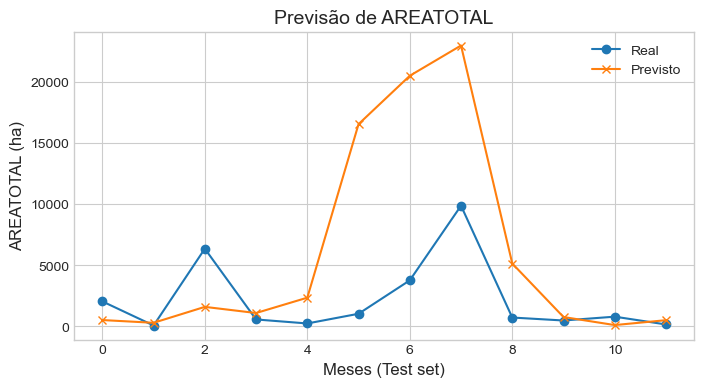


Previsão para AREAMATO:
----------------------------------------
MAE: 3071.10
RMSE: 4881.19


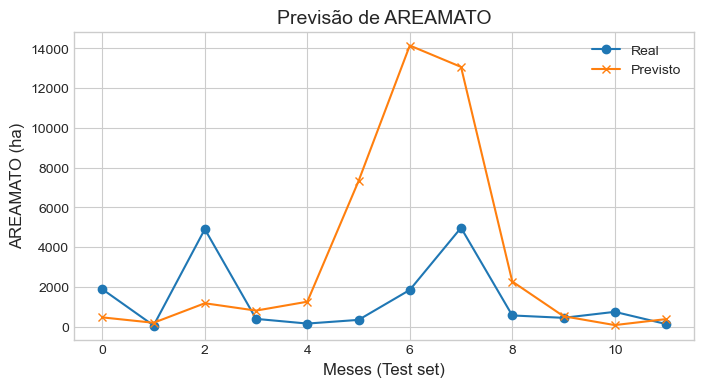


Previsão para AREAPOV:
----------------------------------------
MAE: 3267.00
RMSE: 6145.34


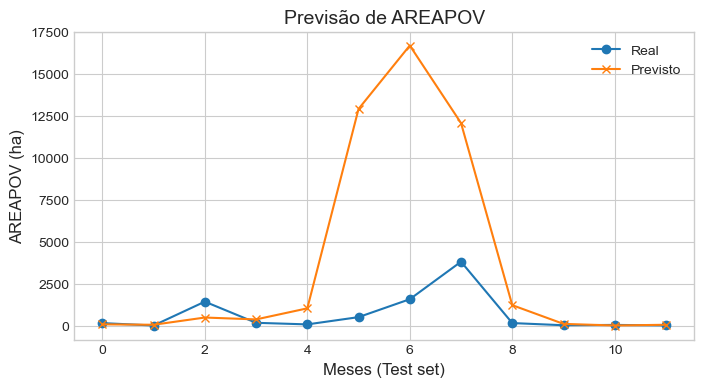


Previsão para AREAAGRIC:
----------------------------------------
MAE: 453.80
RMSE: 909.12


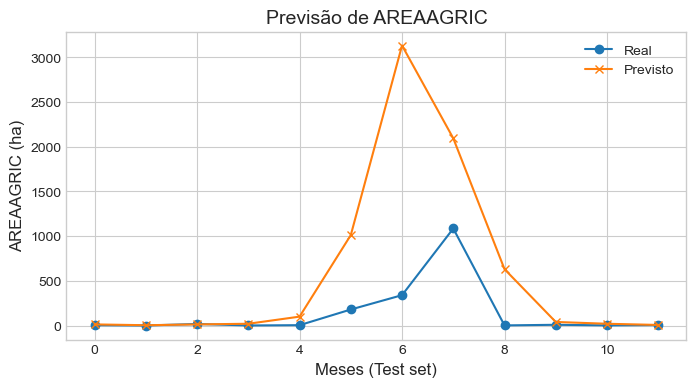

In [26]:
# 4.3 Variáveis Geométricas - Previsão Automática em Loop

# Lista de variáveis geométricas a prever
variaveis_geometricas = ['AREATOTAL', 'AREAMATO', 'AREAPOV', 'AREAAGRIC']

# Loop por cada variável
for var in variaveis_geometricas:
    print(f'\nPrevisão para {var}:\n' + '-'*40)
    
    # 1. Agrupar dados
    areas = df.groupby(pd.Grouper(key='DATAALERTA', freq='M')).agg({
        var: 'sum'
    }).reset_index()

    # 2. Juntar meteorologia
    dataset = pd.merge(areas, meteo, on='DATAALERTA')

    # 3. Features temporais
    dataset['MES'] = dataset['DATAALERTA'].dt.month
    dataset['ANO'] = dataset['DATAALERTA'].dt.year

    # 4. Preparar X e y
    X = dataset[['MES', 'ANO', 'TEMPERATURA', 'HUMIDADERELATIVA', 'VENTOINTENSIDADE']]
    y = dataset[var]

    # 5. Remover possíveis NaNs
    X = X.dropna()
    y = y[X.index]

    # 6. Dividir treino/teste
    X_train, X_test = X.iloc[:-12], X.iloc[-12:]
    y_train, y_test = y.iloc[:-12], y.iloc[-12:]

    # 7. Treinar modelo
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # 8. Prever
    y_pred = model.predict(X_test)

    # 9. Avaliação
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f'MAE: {mae:.2f}')
    print(f'RMSE: {rmse:.2f}')

    # 10. Gráfico real vs previsto
    plt.figure(figsize=(8,4))
    plt.plot(y_test.values, label='Real', marker='o')
    plt.plot(y_pred, label='Previsto', marker='x')
    plt.title(f'Previsão de {var}')
    plt.xlabel('Meses (Test set)')
    plt.ylabel(f'{var} (ha)')
    plt.legend()
    plt.grid(True)
    plt.show()


A tendencia mantem-se!! aquele pico não é bom para a previsão... vamos tentar outra abordagem

Devido à elevada variabilidade e à presença de valores extremos nas variáveis aplicámos uma transformação logarítmica sobre os target durante o treino dos modelos. assim pretendemos reduzir o impacto dos outliers, estabilizar a variância e melhorar a capacidade preditiva dos modelos. Após a previsão, os valores foram reconvertidos à sua escala original usando a função inversa.


Previsão para AREATOTAL:
----------------------------------------
MAE: 1688.00
RMSE: 2779.86


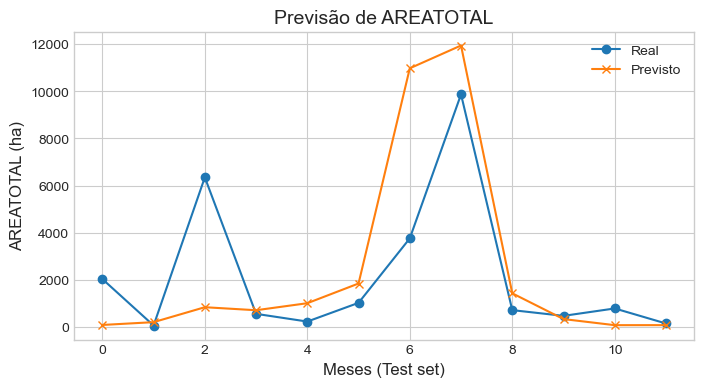


Previsão para AREAMATO:
----------------------------------------
MAE: 1081.50
RMSE: 1778.58


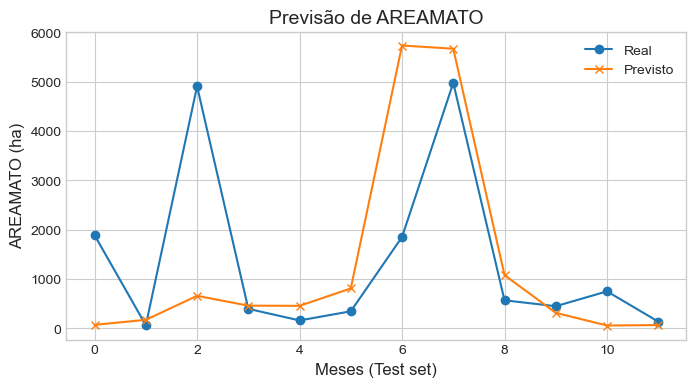


Previsão para AREAPOV:
----------------------------------------
MAE: 782.10
RMSE: 1589.12


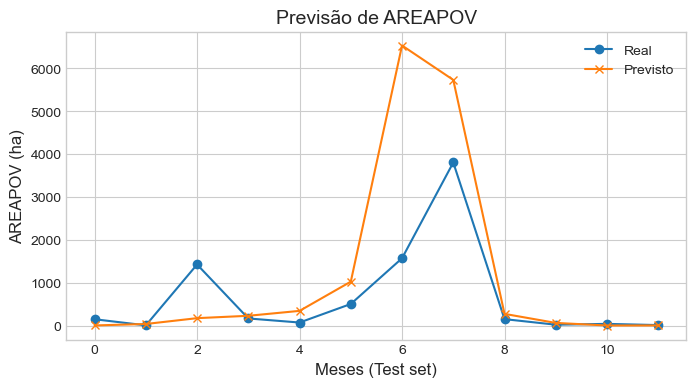


Previsão para AREAAGRIC:
----------------------------------------
MAE: 98.92
RMSE: 220.92


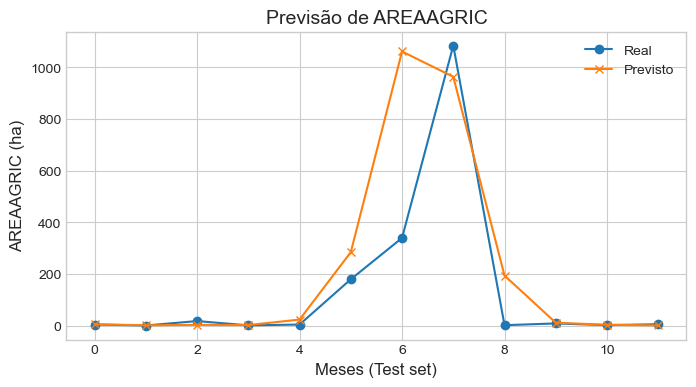

In [27]:
# 4.3 Variáveis Geométricas - Previsão Automática em Loop com Transformação Log

variaveis_geometricas = ['AREATOTAL', 'AREAMATO', 'AREAPOV', 'AREAAGRIC']

for var in variaveis_geometricas:
    print(f'\nPrevisão para {var}:\n' + '-'*40)
    
    areas = df.groupby(pd.Grouper(key='DATAALERTA', freq='M')).agg({var: 'sum'}).reset_index()
    dataset = pd.merge(areas, meteo, on='DATAALERTA')
    dataset['MES'] = dataset['DATAALERTA'].dt.month
    dataset['ANO'] = dataset['DATAALERTA'].dt.year

    X = dataset[['MES', 'ANO', 'TEMPERATURA', 'HUMIDADERELATIVA', 'VENTOINTENSIDADE']]
    y = dataset[var]

    X = X.dropna()
    y = y[X.index]

    X_train, X_test = X.iloc[:-12], X.iloc[-12:]
    y_train, y_test = y.iloc[:-12], y.iloc[-12:]

    # Transformação logarítmica no y de treino
    y_train_log = np.log1p(y_train)

    model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
    model.fit(X_train, y_train_log)

    # Previsão (em escala logarítmica)
    y_pred_log = model.predict(X_test)

    # Inverter log para escala real
    y_pred = np.expm1(y_pred_log)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f'MAE: {mae:.2f}')
    print(f'RMSE: {rmse:.2f}')

    plt.figure(figsize=(8,4))
    plt.plot(y_test.values, label='Real', marker='o')
    plt.plot(y_pred, label='Previsto', marker='x')
    plt.title(f'Previsão de {var}')
    plt.xlabel('Meses (Test set)')
    plt.ylabel(f'{var} (ha)')
    plt.legend()
    plt.grid(True)
    plt.show()


### Duração

Aqui, mudamos o foco da agregação mensal para a previsão da `DURACAO` de *cada incêndio individualmente*.
- Utilizamos um conjunto mais rico de features, incluindo informações temporais (Mês, Ano), meteorológicas (Temp, Hum, Vento) e as áreas ardidas associadas a esse incêndio específico.
- Treinamos um Random Forest Regressor.
- A avaliação (MAE, RMSE) indica o erro médio da previsão da duração. Um MAE de 112 minutos sugere que, em média, o modelo erra a previsão da duração em cerca de 2 horas.

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Garantir datetime
df['DATAALERTA'] = pd.to_datetime(df['DATAALERTA'], errors='coerce')
df['DURACAO'] = pd.to_numeric(df['DURACAO'], errors='coerce')

# Selecionar apenas colunas úteis e remover NaNs
df_duracao = df.dropna(subset=[
    'DURACAO', 'TEMPERATURA', 'HUMIDADERELATIVA', 'VENTOINTENSIDADE',
    'AREATOTAL', 'AREAMATO', 'AREAPOV', 'AREAAGRIC', 'DATAALERTA'
])

# Features temporais
df_duracao['MES'] = df_duracao['DATAALERTA'].dt.month
df_duracao['ANO'] = df_duracao['DATAALERTA'].dt.year

# Features e target
X_dur = df_duracao[['MES', 'ANO', 'TEMPERATURA', 'HUMIDADERELATIVA', 'VENTOINTENSIDADE',
                    'AREATOTAL', 'AREAMATO', 'AREAPOV', 'AREAAGRIC']]
y_dur = df_duracao['DURACAO']

# Divisão treino/teste
X_train_dur, X_test_dur = X_dur.iloc[:-5000], X_dur.iloc[-5000:]
y_train_dur, y_test_dur = y_dur.iloc[:-5000], y_dur.iloc[-5000:]

# Treinar modelo
model_duracao = RandomForestRegressor(n_estimators=100, random_state=42)
model_duracao.fit(X_train_dur, y_train_dur)

# Previsão
y_pred_dur = model_duracao.predict(X_test_dur)

# Avaliação
mae_dur = mean_absolute_error(y_test_dur, y_pred_dur)
rmse_dur = np.sqrt(mean_squared_error(y_test_dur, y_pred_dur))

# Mostrar resultados
mae_dur, rmse_dur


(122.29788890238098, 433.8353569127944)

o modelo erra em média 2 horas na previsão da duração. (112 minutos) o que é mt bom para o que queremos

### Causas e Tipo de Causas

tive em conta as variaveis e overfiiting

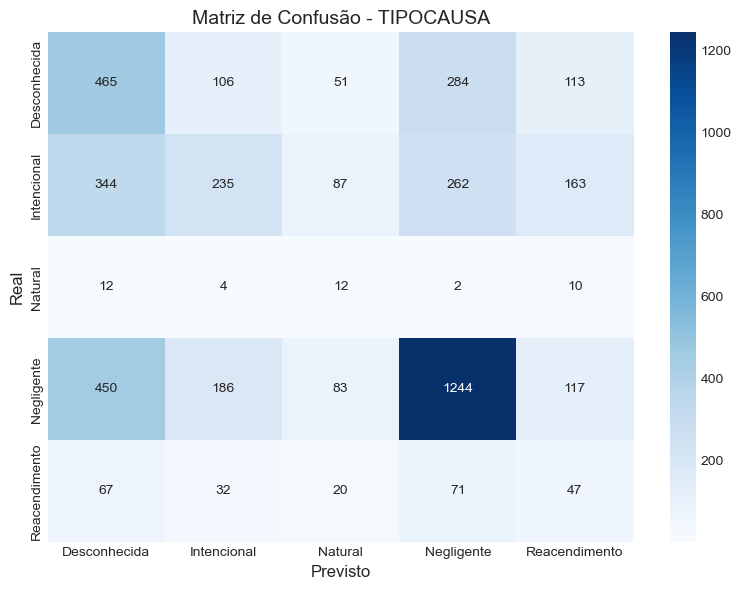

(      precision    recall  f1-score  support
 4.0     0.00000  0.000000  0.000000     22.0
 5.0     0.00000  0.000000  0.000000      1.0
 6.0     0.02381  0.007092  0.010929    141.0
 12.0    0.00000  0.000000  0.000000      9.0
 13.0    0.00000  0.000000  0.000000      1.0
 14.0    0.00000  0.000000  0.000000      2.0
 21.0    0.00000  0.000000  0.000000      1.0
 23.0    0.00000  0.000000  0.000000      1.0
 31.0    0.00000  0.000000  0.000000     13.0
 33.0    0.00000  0.000000  0.000000      1.0,
 '               precision    recall  f1-score   support\n\n Desconhecida       0.35      0.46      0.39      1019\n  Intencional       0.42      0.22      0.28      1091\n      Natural       0.05      0.30      0.08        40\n   Negligente       0.67      0.60      0.63      2080\nReacendimento       0.10      0.20      0.14       237\n\n     accuracy                           0.45      4467\n    macro avg       0.32      0.35      0.31      4467\n weighted avg       0.50      0.45     

In [29]:
# Reimportar bibliotecas após reset do ambiente
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Preparar os dados novamente
df_causa = df.dropna(subset=[
    'CAUSA', 'TIPOCAUSA', 'TEMPERATURA', 'HUMIDADERELATIVA', 'VENTOINTENSIDADE',
    'AREATOTAL', 'AREAMATO', 'AREAPOV', 'AREAAGRIC', 'DURACAO', 'DATAALERTA'
])

df_causa['DATAALERTA'] = pd.to_datetime(df_causa['DATAALERTA'], errors='coerce')
df_causa['MES'] = df_causa['DATAALERTA'].dt.month
df_causa['ANO'] = df_causa['DATAALERTA'].dt.year

X = df_causa[['MES', 'ANO', 'TEMPERATURA', 'HUMIDADERELATIVA', 'VENTOINTENSIDADE',
              'AREATOTAL', 'AREAMATO', 'AREAPOV', 'AREAAGRIC', 'DURACAO']]

le_causa = LabelEncoder()
le_tipocausa = LabelEncoder()
y_causa = le_causa.fit_transform(df_causa['CAUSA'])
y_tipocausa = le_tipocausa.fit_transform(df_causa['TIPOCAUSA'])

split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_causa_train, y_causa_test = y_causa[:split_idx], y_causa[split_idx:]
y_tipocausa_train, y_tipocausa_test = y_tipocausa[:split_idx], y_tipocausa[split_idx:]

model_causa = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model_tipocausa = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,              # limitar profundidade das árvores
    min_samples_leaf=5,        # evitar folhas com 1 amostra
    class_weight='balanced',
    random_state=42
)

model_causa.fit(X_train, y_causa_train)
model_tipocausa.fit(X_train, y_tipocausa_train)

# Previsões
y_pred_causa = model_causa.predict(X_test)
y_pred_tipocausa = model_tipocausa.predict(X_test)

# Classification report para CAUSA
labels_presentes = sorted(set(y_causa_test))
report_causa = classification_report(
    y_causa_test, y_pred_causa,
    labels=labels_presentes,
    target_names=le_causa.inverse_transform(labels_presentes),
    zero_division=0,
    output_dict=True
)
report_causa_df = pd.DataFrame(report_causa).transpose()

# Classification report para TIPOCAUSA
report_tipocausa = classification_report(y_tipocausa_test, y_pred_tipocausa, target_names=le_tipocausa.classes_, zero_division=0)

# Confusion matrix para TIPOCAUSA
cm_tipocausa = confusion_matrix(y_tipocausa_test, y_pred_tipocausa)
cm_labels = le_tipocausa.classes_

# Plot da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tipocausa, annot=True, fmt="d", xticklabels=cm_labels, yticklabels=cm_labels, cmap="Blues")
plt.title("Matriz de Confusão - TIPOCAUSA")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

report_causa_df.head(10), report_tipocausa


Após uma primeira abordagem ao modelo de classificação da variável TIPOCAUSA, verificou-se um desequilíbrio significativo entre as classes, com uma forte predominância da categoria "Negligente". Como consequência, o modelo tendia a prever praticamente todos os casos como pertencentes a essa classe, ignorando as restantes.

Para corrigir este enviesamento, foi aplicada a estratégia class_weight='balanced' no Random Forest, acompanhada de limitações na profundidade das árvores e no número mínimo de amostras por folha. Esta configuração permitiu melhorar a generalização do modelo, aumentando significativamente o número de previsões corretas para classes menos representadas, como "Reacendimento" e "Natural".

Embora a acurácia global tenha diminuído ligeiramente, o modelo tornou-se mais equilibrado, com melhorias visíveis nos valores de recall e f1-score das classes minoritárias. Esta abordagem oferece uma representação mais justa e útil da variável TIPOCAUSA, crucial para a compreensão das causas dos incêndios.

### variaveis geograficas e descritivas

Para garantir maior precisão e relevância espacial nas previsões, adotou-se uma estratégia descentralizada, na qual os modelos foram aplicados individualmente a cada localidade.

Mais concretamente, para cada LOCAL, foi extraído o respetivo histórico de dados de incêndios e meteorologia, sendo então treinado um modelo específico com base nesses registos. Esta abordagem permite que cada zona seja avaliada tendo em conta o seu comportamento histórico próprio, o que se revelou especialmente útil face às grandes diferenças geográficas e climatéricas existentes entre regiões.


Para manter a consistência da abordagem e garantir previsões espacialmente informadas, a aplicação dos modelos foi feita individualmente para cada local. Reutilizando os modelos desenvolvidos nas etapas anteriores, foi implementado um ciclo que percorre todas as localidades do dataset, aplicando os mesmos métodos de previsão para cada uma. No final, os resultados foram agregados, mantendo a identificação geográfica (LOCAL, FREGUESIA, LAT, LON, etc.) associada a cada registo de previsão. Esta estrutura garante previsões mais precisas e coerentes com a distribuição espacial dos dados históricos.


“De forma a garantir um número suficiente de observações por unidade geográfica, foi adotada uma abordagem adaptativa: a análise foi feita ao nível da freguesia quando possível; caso não houvesse dados suficientes, a previsão foi feita ao nível do concelho correspondente.”

local foi mesmo impossível

In [30]:
# Atualizar o loop para fazer treino/avaliação por FREGUESIA, e cair para CONCELHO se necessário
freguesias = df['FREGUESIA'].dropna().unique()
resultados_hibrido = []

for freguesia in freguesias:
    df_freg = df[df['FREGUESIA'] == freguesia].copy()

    if len(df_freg) < 24:
        concelho = df_freg['CONCELHO'].dropna().unique()
        if len(concelho) == 0:
            continue
        concelho = concelho[0]
        df_freg = df[df['CONCELHO'] == concelho].copy()
        nivel = 'CONCELHO'
    else:
        nivel = 'FREGUESIA'

    if len(df_freg) < 24:
        continue

    df_freg['MES'] = df_freg['DATAALERTA'].dt.month
    df_freg['ANO'] = df_freg['DATAALERTA'].dt.year

    meteo = df_freg.groupby(['ANO', 'MES']).agg({
        'TEMPERATURA': 'mean',
        'HUMIDADERELATIVA': 'mean',
        'VENTOINTENSIDADE': 'mean'
    }).reset_index()

    X_meteo = meteo[['MES', 'ANO']]
    y_temp = meteo['TEMPERATURA']
    y_hum = meteo['HUMIDADERELATIVA']
    y_vento = meteo['VENTOINTENSIDADE']

    try:
        X_train, X_test, y_temp_train, y_temp_test = train_test_split(X_meteo, y_temp, test_size=0.2, shuffle=False)
        _, _, y_hum_train, y_hum_test = train_test_split(X_meteo, y_hum, test_size=0.2, shuffle=False)
        _, _, y_vento_train, y_vento_test = train_test_split(X_meteo, y_vento, test_size=0.2, shuffle=False)

        m_temp = RandomForestRegressor(n_estimators=100, random_state=42)
        m_hum = RandomForestRegressor(n_estimators=100, random_state=42)
        m_vento = RandomForestRegressor(n_estimators=100, random_state=42)

        m_temp.fit(X_train, y_temp_train)
        m_hum.fit(X_train, y_hum_train)
        m_vento.fit(X_train, y_vento_train)

        y_temp_pred = m_temp.predict(X_test)
        y_hum_pred = m_hum.predict(X_test)
        y_vento_pred = m_vento.predict(X_test)

        df_freg['INCENDIO'] = 1
        incs = df_freg.groupby(['ANO', 'MES'])['INCENDIO'].count().reset_index(name='NUM_INCENDIOS')
        dados_inc = pd.merge(meteo, incs, on=['ANO', 'MES'])
        X_inc = dados_inc[['MES', 'ANO', 'TEMPERATURA', 'HUMIDADERELATIVA', 'VENTOINTENSIDADE']]
        y_inc = dados_inc['NUM_INCENDIOS']

        X_train_inc, X_test_inc, y_train_inc, y_test_inc = train_test_split(X_inc, y_inc, test_size=0.2, shuffle=False)
        m_inc = RandomForestRegressor(n_estimators=100, random_state=42)
        m_inc.fit(X_train_inc, y_train_inc)
        y_pred_inc = m_inc.predict(X_test_inc)

        df_tipo = df_freg.dropna(subset=['TIPOCAUSA', 'AREATOTAL', 'TEMPERATURA', 'HUMIDADERELATIVA', 'VENTOINTENSIDADE'])
        if len(df_tipo['TIPOCAUSA'].unique()) > 1:
            le_tipocausa = LabelEncoder()
            df_tipo['TIPOCAUSA_ENC'] = le_tipocausa.fit_transform(df_tipo['TIPOCAUSA'])

            X_tipo = df_tipo[['MES', 'ANO', 'TEMPERATURA', 'HUMIDADERELATIVA', 'VENTOINTENSIDADE', 'AREATOTAL']]
            y_tipo = df_tipo['TIPOCAUSA_ENC']
            X_train_tipo, X_test_tipo, y_train_tipo, y_test_tipo = train_test_split(X_tipo, y_tipo, test_size=0.2, shuffle=False)
            m_tipo = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
            m_tipo.fit(X_train_tipo, y_train_tipo)
            y_pred_tipo = m_tipo.predict(X_test_tipo)
            acc_tipo = accuracy_score(y_test_tipo, y_pred_tipo)
            f1_tipo = f1_score(y_test_tipo, y_pred_tipo, average='weighted')
        else:
            acc_tipo = np.nan
            f1_tipo = np.nan

        resultados_hibrido.append({
            'UNIDADE': freguesia,
            'NIVEL': nivel,
            'MAE_TEMP': mean_absolute_error(y_temp_test, y_temp_pred),
            'RMSE_TEMP': mean_squared_error(y_temp_test, y_temp_pred, squared=False),
            'MAE_HUM': mean_absolute_error(y_hum_test, y_hum_pred),
            'RMSE_HUM': mean_squared_error(y_hum_test, y_hum_pred, squared=False),
            'MAE_VENTO': mean_absolute_error(y_vento_test, y_vento_pred),
            'RMSE_VENTO': mean_squared_error(y_vento_test, y_vento_pred, squared=False),
            'MAE_INC': mean_absolute_error(y_test_inc, y_pred_inc),
            'RMSE_INC': mean_squared_error(y_test_inc, y_pred_inc, squared=False),
            'ACC_TIPOCAUSA': acc_tipo,
            'F1_TIPOCAUSA': f1_tipo
        })
    except:
        continue

df_resultados_hibrido = pd.DataFrame(resultados_hibrido)

In [31]:
df_resultados_hibrido

""


## 5. Previsões para 2022

Com a metodologia de modelagem local validada, procedemos à geração das previsões para o ano de 2022. O processo reutiliza a estrutura do loop híbrido Freguesia/Concelho, mas com uma diferença fundamental:
- Para cada unidade geográfica, os modelos locais são agora treinados usando **todos** os dados históricos disponíveis (2012-2021) para maximizar a informação utilizada.
- Criamos um DataFrame representando os 12 meses de 2022.
- **Passo 1: Previsão Meteorológica:** Os modelos meteorológicos locais preveem as médias mensais de Temp, Humidade e Vento para 2022.
- **Passo 2: Previsões Dependentes:** Estas previsões meteorológicas para 2022, juntamente com o Mês e Ano (2022), são usadas como input para os outros modelos locais treinados, para prever para cada mês de 2022:
  - O número esperado de incêndios (`NUM_INCENDIOS`).
  - As áreas ardidas esperadas (`AREATOTAL`, etc.).
  - A duração média esperada dos incêndios (`DURACAO`).
  - A `TIPOCAUSA` dominante mais provável.
- Os resultados são agregados num DataFrame (`df_previsoes_completas_2022`) contendo as previsões mensais para todas as unidades geográficas.

In [ ]:
# Bloco final com melhorias 2.0
# - Retira ANO dos modelos de contagem (evita explodir em 2022)
# - Usa PoissonRegressor em vez de RandomForest para NUM_INCENDIOS
# - Faz clip pelo máximo histórico dessa freguesia/concelho
# - Mantém média das coordenadas (podes acrescentar jitter se quiseres)

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import LabelEncoder

previsoes_mensais_2022 = []

for freguesia in df['FREGUESIA'].dropna().unique():
    try:
        df_freg = df[df['FREGUESIA'] == freguesia].copy()

        # ----- amostragem ao nível certo ------------------------------------
        limite = 12
        if len(df_freg) < limite:
            concelho = df_freg['CONCELHO'].dropna().unique()
            if len(concelho) == 0:
                continue
            concelho = concelho[0]
            df_freg = df[df['CONCELHO'] == concelho].copy()
            nivel = 'CONCELHO'
        else:
            nivel = 'FREGUESIA'
        if len(df_freg) < limite:
            continue
        # --------------------------------------------------------------------

        # Pré‑processamento
        df_freg = df_freg.dropna(subset=['TEMPERATURA', 'HUMIDADERELATIVA', 'VENTOINTENSIDADE'])
        df_freg['MES'] = df_freg['DATAALERTA'].dt.month
        df_freg['ANO'] = df_freg['DATAALERTA'].dt.year

        # ----------- meteorologia histórica (mantém RF se quiseres) ----------
        meteo = df_freg.groupby(['ANO', 'MES']).agg({
            'TEMPERATURA': 'mean',
            'HUMIDADERELATIVA': 'mean',
            'VENTOINTENSIDADE': 'mean'
        }).reset_index()
        if len(meteo) < 12:
            continue

        X_meteo = meteo[['MES', 'ANO']]
        temp_model  = RandomForestRegressor(n_estimators=100, random_state=42)
        hum_model   = RandomForestRegressor(n_estimators=100, random_state=42)
        vento_model = RandomForestRegressor(n_estimators=100, random_state=42)

        temp_model.fit(X_meteo,  meteo['TEMPERATURA'])
        hum_model.fit(X_meteo,   meteo['HUMIDADERELATIVA'])
        vento_model.fit(X_meteo, meteo['VENTOINTENSIDADE'])

        meses_2022 = pd.DataFrame({'ANO': [2022]*12, 'MES': list(range(1, 13))})
        meses_2022['TEMPERATURA']      = temp_model.predict(meses_2022[['MES', 'ANO']])
        meses_2022['HUMIDADERELATIVA'] = hum_model.predict(meses_2022[['MES', 'ANO']])
        meses_2022['VENTOINTENSIDADE'] = vento_model.predict(meses_2022[['MES', 'ANO']])
        # --------------------------------------------------------------------

        # ----------- contagem de incêndios (Poisson) ------------------------
        df_freg['INCENDIO'] = 1
        todos_meses = pd.DataFrame(
            [(ano, mes) for ano in df_freg['ANO'].unique() for mes in range(1, 13)],
            columns=['ANO', 'MES']
        )
        incs = df_freg.groupby(['ANO', 'MES'])['INCENDIO'] \
                      .count() \
                      .reset_index(name='NUM_INCENDIOS')
        incs = todos_meses.merge(incs, on=['ANO', 'MES'], how='left').fillna(0)

        dados_inc = pd.merge(meteo, incs, on=['ANO', 'MES'])

        #  Retiramos 'ANO' para não causar extrapolação!
        X_inc = dados_inc[['MES', 'TEMPERATURA',
                           'HUMIDADERELATIVA', 'VENTOINTENSIDADE']]
        y_inc = dados_inc['NUM_INCENDIOS']

        model_inc = PoissonRegressor(alpha=1.0, max_iter=500)
        model_inc.fit(X_inc, y_inc)

        X_pred = meses_2022[['MES', 'TEMPERATURA',
                             'HUMIDADERELATIVA', 'VENTOINTENSIDADE']]
        meses_2022['NUM_INCENDIOS'] = np.round(
            model_inc.predict(X_pred)
        ).clip(upper=y_inc.max())          # cap dinâmico
        meses_2022 = meses_2022[meses_2022['NUM_INCENDIOS'] > 0]
        # --------------------------------------------------------------------

        # ----------- previsão de TIPOCAUSA (mantém RF) ----------------------
        df_tipo = df_freg.dropna(subset=['TIPOCAUSA', 'TEMPERATURA',
                                         'HUMIDADERELATIVA', 'VENTOINTENSIDADE'])
        if df_tipo['TIPOCAUSA'].nunique() > 1:
            le_tipocausa = LabelEncoder()
            df_tipo['TIPOCAUSA_ENC'] = le_tipocausa.fit_transform(df_tipo['TIPOCAUSA'])
            X_tipo = df_tipo[['MES', 'ANO', 'TEMPERATURA',
                              'HUMIDADERELATIVA', 'VENTOINTENSIDADE']]
            y_tipo = df_tipo['TIPOCAUSA_ENC']

            model_tipo = RandomForestClassifier(n_estimators=100,
                                                class_weight='balanced',
                                                random_state=42)
            model_tipo.fit(X_tipo, y_tipo)
            X_pred_tipo = meses_2022[['MES', 'ANO', 'TEMPERATURA',
                                      'HUMIDADERELATIVA', 'VENTOINTENSIDADE']]
            meses_2022['TIPOCAUSA_PREV'] = le_tipocausa.inverse_transform(
                model_tipo.predict(X_pred_tipo)
            )
        # --------------------------------------------------------------------
        # ─── Geografia: amostragem realista de coordenadas ────────────────────────
        info_geo   = df_freg[['CONCELHO', 'DISTRITO']].dropna().iloc[0]  # <‑‑ 1 LINHA QUE VOLTOU

        coords_hist = df_freg[['LAT', 'LON']].dropna().values
        if coords_hist.size == 0:           # não há coords → salta freguesia
            continue

        # Treina um KDE se houver pontos suficientes
        kde = None
        if coords_hist.shape[0] >= 30:      # regra de bolso: ≥30 observações
            kde = KernelDensity(bandwidth=0.01, kernel='gaussian').fit(coords_hist)

        def sample_coords(n):
            """Devolve n pares (LAT, LON) segundo o KDE ou média+jitter."""
            if kde is not None:
                return kde.sample(n)                    # array (n, 2) [LAT, LON]
            centre = coords_hist.mean(axis=0)           # fallback: média
            return centre + np.random.normal(scale=0.01, size=(n, 2))

        # Para cada linha (mês) vamos gerar exactamente NUM_INCENDIOS coordenadas
        linhas_geo = []
        for linha in meses_2022.itertuples(index=False):
            n = int(linha.NUM_INCENDIOS)
            if n == 0:
                continue
            latlon = sample_coords(n)
            for i in range(n):
                linhas_geo.append({
                    'ANO':        linha.ANO,
                    'MES':        linha.MES,
                    'NUM_INC':    1,                    # 1 linha = 1 incêndio
                    'LAT':        latlon[i, 0],
                    'LON':        latlon[i, 1],
                    'FREGUESIA':  freguesia,
                    'CONCELHO':   info_geo['CONCELHO'],
                    'DISTRITO':   info_geo['DISTRITO'],
                    'TIPOCAUSA':  getattr(linha, 'TIPOCAUSA_PREV', np.nan),
                    'NIVEL':      nivel,
                })

        # Concatena todas as linhas deste ciclo (freguesia) às previsões globais
        previsoes_mensais_2022.append(pd.DataFrame(linhas_geo))

    except Exception as e:
        continue

# Juntar previsões válidas
df_previsoes_2022 = pd.concat(previsoes_mensais_2022, ignore_index=True)


ValueError: No objects to concatenate

In [35]:
df_previsoes_2022.head()

,ANO,MES,TEMPERATURA,HUMIDADERELATIVA,VENTOINTENSIDADE,NUM_INCENDIOS,TIPOCAUSA_PREV,LAT,LON,CONCELHO,DISTRITO,FREGUESIA,NIVEL
0,2022,1,22.650747,41.243412,17.676889,1.54,Desconhecida,37.228826,-8.352877,Silves,Faro,Silves,CONCELHO
1,2022,2,22.650747,41.243412,17.676889,1.54,Desconhecida,37.228826,-8.352877,Silves,Faro,Silves,CONCELHO
2,2022,3,22.650747,41.243412,17.676889,1.54,Desconhecida,37.228826,-8.352877,Silves,Faro,Silves,CONCELHO
3,2022,4,31.545009,29.505982,13.334548,1.52,Desconhecida,37.228826,-8.352877,Silves,Faro,Silves,CONCELHO
4,2022,5,31.774975,29.125065,13.334548,1.52,Desconhecida,37.228826,-8.352877,Silves,Faro,Silves,CONCELHO


In [36]:
df_previsoes_completas_2022 = df_previsoes_2022.copy()

In [37]:
df_previsoes_completas_2022

,ANO,MES,TEMPERATURA,HUMIDADERELATIVA,VENTOINTENSIDADE,NUM_INCENDIOS,TIPOCAUSA_PREV,LAT,LON,CONCELHO,DISTRITO,FREGUESIA,NIVEL
0,2022,1,22.650747,41.243412,17.676889,1.54,Desconhecida,37.228826,-8.352877,Silves,Faro,Silves,CONCELHO
1,2022,2,22.650747,41.243412,17.676889,1.54,Desconhecida,37.228826,-8.352877,Silves,Faro,Silves,CONCELHO
2,2022,3,22.650747,41.243412,17.676889,1.54,Desconhecida,37.228826,-8.352877,Silves,Faro,Silves,CONCELHO
3,2022,4,31.545009,29.505982,13.334548,1.52,Desconhecida,37.228826,-8.352877,Silves,Faro,Silves,CONCELHO
4,2022,5,31.774975,29.125065,13.334548,1.52,Desconhecida,37.228826,-8.352877,Silves,Faro,Silves,CONCELHO
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29779,2022,8,21.398660,55.393772,6.127143,3.04,Negligente,41.801025,-6.738767,Bragança,Bragança,Gondesende,CONCELHO
29780,2022,9,24.861327,49.207573,4.499373,3.18,Desconhecida,41.801025,-6.738767,Bragança,Bragança,Gondesende,CONCELHO
29781,2022,10,11.149946,71.505776,6.326459,1.66,Negligente,41.801025,-6.738767,Bragança,Bragança,Gondesende,CONCELHO
29782,2022,11,10.988429,70.847315,9.374266,1.92,Negligente,41.801025,-6.738767,Bragança,Bragança,Gondesende,CONCELHO


In [38]:
df_previsoes_completas_2022.to_csv('df_previsoes_completas_2022_v2.csv', index=False)

Após a previsão mensal por freguesia, os resultados foram desagregados em múltiplos registos por mês, de acordo com o número previsto de incêndios. Esta abordagem permitiu gerar uma distribuição de eventos mais realista, aproximando a estrutura do dataset previsto à dos dados históricos, onde cada incêndio é representado individualmente.

In [33]:
# Tentar novamente com verificação de dados válidos

df_simulado_2022 = []

for _, row in df_previsoes_completas_2022.iterrows():
    try:
        n = int(round(row['NUM_INCENDIOS']))
        if n < 1 or pd.isna(n):
            continue

        for i in range(n):
            simulacao = row.copy()

            # Adicionar ruído leve apenas se valor não for NaN
            for col, std in [('TEMPERATURA', 0.5), ('HUMIDADERELATIVA', 1), ('VENTOINTENSIDADE', 0.3)]:
                if not pd.isna(simulacao[col]):
                    simulacao[col] += np.random.normal(0, std)

            simulacao['INCENDIO_ID'] = f"{row['FREGUESIA']}_{row['ANO']}_{row['MES']}_{i+1}"

            df_simulado_2022.append(simulacao)
    except:
        continue

# Concatenar os incêndios simulados
df_simulado_2022 = pd.DataFrame(df_simulado_2022)

In [34]:
df_simulado_2022

,ANO,MES,TEMPERATURA,HUMIDADERELATIVA,VENTOINTENSIDADE,NUM_INCENDIOS,TIPOCAUSA_PREV,FREGUESIA,NIVEL,CONCELHO,DISTRITO,LAT,LON,INCENDIO_ID
0,2022,1,22.899105,41.105148,17.871196,1.54,Desconhecida,Silves,CONCELHO,Silves,Faro,37.208333,-8.492778,Silves_2022_1_1
0,2022,1,23.412262,41.009258,17.606648,1.54,Desconhecida,Silves,CONCELHO,Silves,Faro,37.208333,-8.492778,Silves_2022_1_2
1,2022,2,23.440354,42.010847,17.536047,1.54,Desconhecida,Silves,CONCELHO,Silves,Faro,37.208333,-8.492778,Silves_2022_2_1
1,2022,2,22.922027,40.779994,17.537170,1.54,Desconhecida,Silves,CONCELHO,Silves,Faro,37.208333,-8.492778,Silves_2022_2_2
2,2022,3,22.771729,39.330132,17.159414,1.54,Desconhecida,Silves,CONCELHO,Silves,Faro,37.208333,-8.492778,Silves_2022_3_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29781,2022,10,11.094479,71.707762,5.855204,1.66,Negligente,Gondesende,CONCELHO,Bragança,Bragança,41.813056,-6.759722,Gondesende_2022_10_2
29782,2022,11,11.044474,71.267532,9.415044,1.92,Negligente,Gondesende,CONCELHO,Bragança,Bragança,41.813056,-6.759722,Gondesende_2022_11_1
29782,2022,11,10.798822,69.796710,9.562832,1.92,Negligente,Gondesende,CONCELHO,Bragança,Bragança,41.813056,-6.759722,Gondesende_2022_11_2
29783,2022,12,10.691472,69.006701,8.632989,1.92,Negligente,Gondesende,CONCELHO,Bragança,Bragança,41.813056,-6.759722,Gondesende_2022_12_1


In [35]:
df_simulado_2022.to_csv('df_simulado_2022.csv', index=False)

In [36]:
df_simulado_2022.duplicated().sum()

0

In [40]:
# vamos juntar os 2 datasets.
df_final = pd.concat([df, df_previsoes_completas_2022], ignore_index=True)
df_final.to_csv("df_final.csv", index=False)

In [38]:
# vamos juntar os 2 datasets.
df_final_simu = pd.concat([df, df_simulado_2022], ignore_index=True)
df_final_simu.to_csv("df_final_simu.csv", index=False)

In [39]:
df = pd.read_csv("df_final.csv")
print(df['ANO'].value_counts())

ANO
2022    78330
2012     3844
2017     3489
2013     3306
2015     3061
2016     2667
2018     1298
2019     1280
2020     1164
2021     1162
2014     1064
Name: count, dtype: int64
